In [171]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Exploratory data analysis


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

# Objectif :

Comprendre nos données

Développer une première stratégie de modélisation 

# Résumé : 


## 5. Wordclouds & contenu lexical

### Non-catastrophe (`target = 0`)
- Mots fréquents : `like`, `just`, `i'm`, `it's`, `day`, `people`, `life`, etc.
- Ton personnel, émotionnel, parfois ironique ou banal.

### Catastrophe (`target = 1`)
- Mots fréquents : `suicide`, `disaster`, `killed`, `evacuated`, `wreckage`, `police`, etc.
- Ton dramatique, informatif, orienté crise ou urgence.

✅ Le contenu lexical brut est **déjà discriminant** entre les deux classes.

---

## 6. Analyse des localisations

| Classe                | Top localisations |
|-----------------------|-------------------|
| Non-catastrophe (0)   | New York, USA, London, CA, UK |
| Catastrophe (1)       | USA, Nigeria, India, California, UK |

📌 Les tweets catastrophes font plus souvent référence à des **zones de crise ou pays en développement**.

---

## 7. Analyse des `keywords`

| Keyword (target = 0) | Freq | Keyword (target = 1) | Freq |
|----------------------|------|-----------------------|------|
| body bags            | 40   | derailment            | 39   |
| armageddon           | 37   | outbreak              | 39   |
| harm                 | 37   | wreckage              | 39   |
| deluge               | 36   | oil spill             | 37   |
| ruin                 | 36   | typhoon               | 37   |

✅ Les `keywords` catastrophes sont **clairement liés à des événements réels**. À l'inverse, certains keywords du groupe 0 peuvent être ironiques ou hors contexte.

---

## Conclusion de l’EDA

- Les tweets urgents (catastrophes) se distinguent par leur **longueur, densité d’information, et lexique dramatique**.
- Certaines variables (`url_count`, `char_count`, `punctuation_count`) sont **fortement discriminantes**.
- `location` et `keyword` sont **secondaires** mais peuvent être utiles combinés au texte.
- L’analyse textuelle confirme que la **nature des mots** (suicide, disaster, evacuated…) est un signal fort.




In [172]:
df = pd.read_csv("../data/train_tweets.csv")


## Apercu des valeurs 

In [173]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [174]:
df.dtypes.value_counts()

object    3
int64     2
Name: count, dtype: int64

In [175]:
df.shape

(7613, 5)

<Axes: >

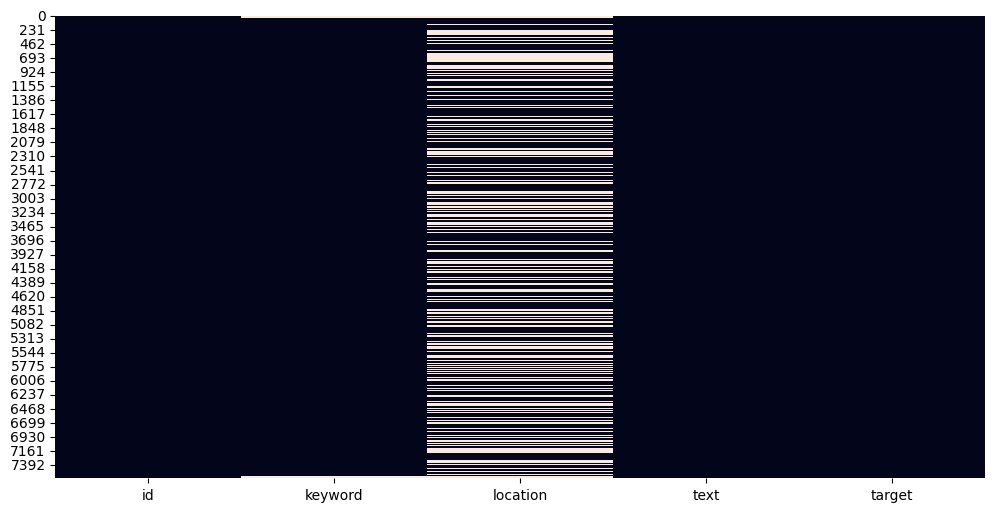

In [176]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)

In [179]:
duplicate = df.duplicated().sum()  # nombre de doublons
print(f"Doublons :", duplicate)

Doublons : 0


In [180]:
df.drop_duplicates(inplace=True)  # suppression des doublons
print(f"Doublons après suppression :", df.duplicated().sum())

Doublons après suppression : 0


In [191]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series.fillna("").astype(str)).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)



# Extraction des top mots
top_words_0 = get_top_words(df_negative["keyword"], 10)
top_words_1 = get_top_words(df_positive["keyword"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,body%20bags,40,derailment,39
1,armageddon,37,outbreak,39
2,harm,37,wreckage,39
3,deluge,36,debris,37
4,ruin,36,oil%20spill,37
5,wrecked,36,typhoon,37
6,explode,35,evacuated,32
7,fear,35,rescuers,32
8,siren,35,suicide%20bomb,32
9,twister,35,suicide%20bombing,32


In [192]:
# Extraction des top mots
top_words_0 = get_top_words(df_negative["location"], 10)
top_words_1 = get_top_words(df_positive["location"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,129,usa,126
1,usa,124,new,80
2,ca,86,ca,57
3,york,77,united,44
4,london,52,nigeria,42
5,united,51,canada,41
6,uk,49,uk,40
7,ny,46,india,34
8,england,44,san,33
9,canada,43,states,33


In [193]:
# Extraction des top mots
top_words_0 = get_top_words(df_negative["text"], 10)
top_words_1 = get_top_words(df_positive["text"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,-,374,-,389
1,like,250,...,106
2,just,229,&amp;,105
3,i'm,195,suicide,103
4,&amp;,190,disaster,97
5,??,183,police,94
6,new,163,people,93
7,it's,124,killed,92
8,don't,122,like,91
9,body,106,california,88


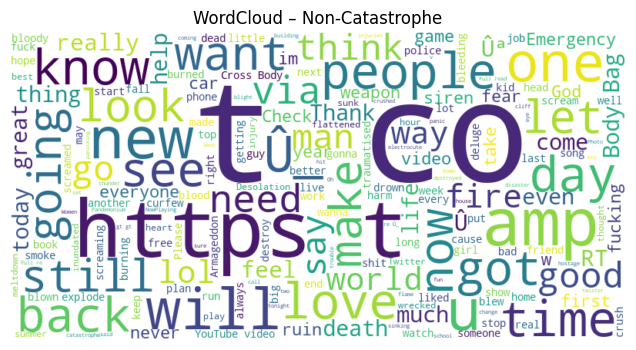

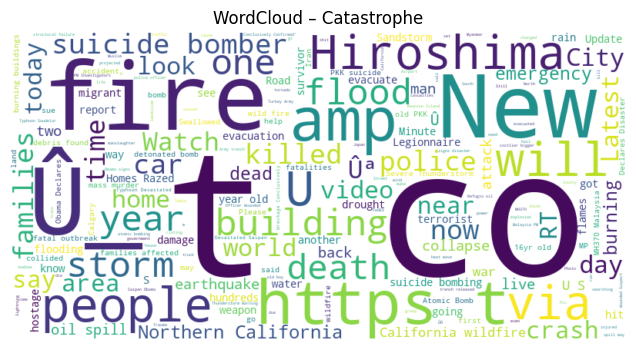

In [194]:
# Concaténer les textes par classe
text_0 = " ".join(df_negative["text"])
text_1 = " ".join(df_positive["text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

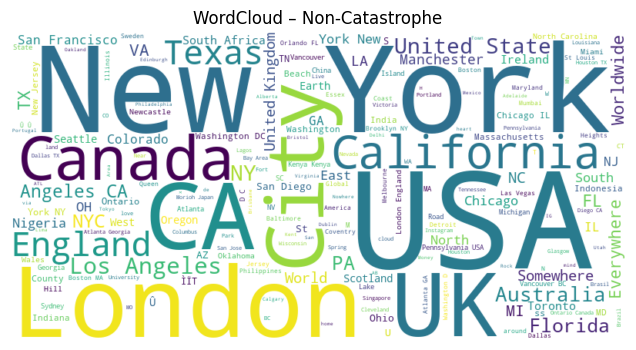

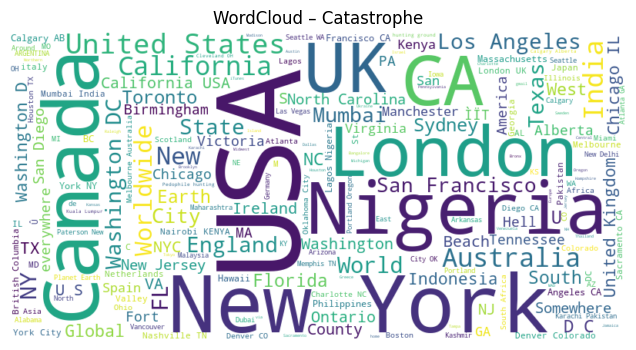

In [195]:
# Concaténer les textes par classe
text_0 = " ".join(df_negative["location"].dropna())
text_1 = " ".join(df_positive["location"].dropna())


# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()
